Employee Sentiment Analysis Project
Objective: Analyze employee communication data to detect sentiment trends, identify flight risks, and predict engagement scores

1. Setup and Data Loading
Import necessary libraries and custom processing modules located in src folder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# import custom modules
from src import sentiment, analytics, modeling

# Load dataset
try:
    df = pd.read_csv('test(in).csv')
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: 'test(in).csv' not found.")

# Preprocessing: convert dates and clean NAs
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['body', 'date', 'from'], inplace=True)

Data Loaded Successfully.


2. Feature Engineering: Context-Aware Sentiment Analysis.
Utilize custom rule-based NLP engine which accounts for negation (not happy) and intensity (very bad) to label emails.

In [2]:
# apply get_sentiment function
df['Sentiment'] = df['body'].apply(sentiment.get_sentiment)

# map to numerical scores for analysis
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['Sentiment_Score'] = df['Sentiment'].map(sentiment_map)

# save augmented data
df.to_csv('test_augmented.csv', index=False)
print("Sentiment Labeling Complete. Data saved to 'test_augmented.csv'.")
print(df[['body', 'Sentiment']].head())

Sentiment Labeling Complete. Data saved to 'test_augmented.csv'.
                                                body Sentiment
0  EnronOptions Announcement\n\n\nWe have updated...   Neutral
1  Marc,\n\nUnfortunately, today is not going to ...   Neutral
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...   Neutral
3  we were thinking papasitos (we can meet somewh...   Neutral
4  Since you never gave me the $20 for the last t...   Neutral


3. EDA
Visualize distribution of sentiment and tracking it over time.

C:\Users\bmant\AppData\Local\Temp\ipykernel_42300\455523425.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])


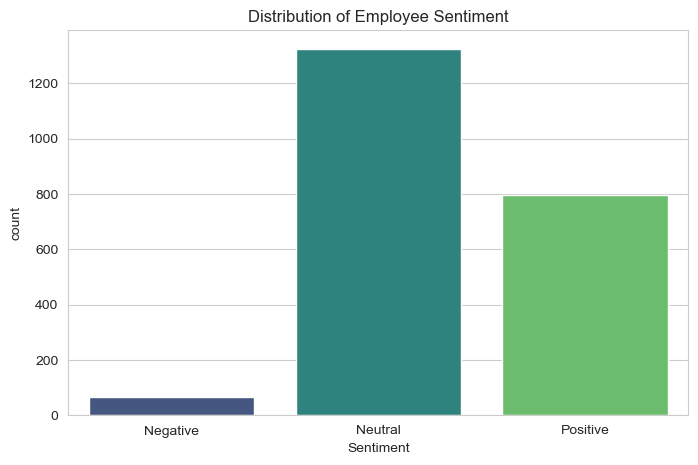

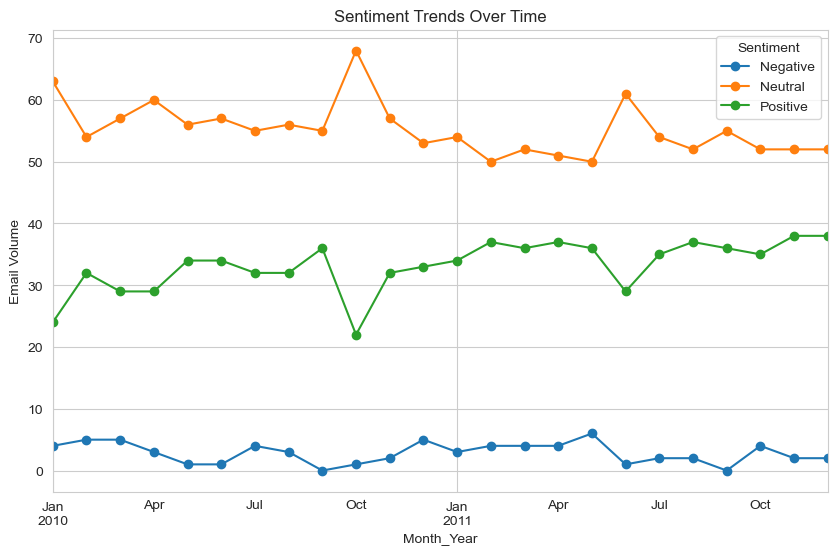

In [3]:
sns.set_style("whitegrid")

# Plot 1: Overall Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment', data=df, palette='viridis', order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Employee Sentiment')
plt.show()

# Plot 2: Monthly Trends
df['Month_Year'] = df['date'].dt.to_period('M')
monthly_trend = df.groupby(['Month_Year', 'Sentiment']).size().unstack().fillna(0)
monthly_trend.plot(kind='line', figsize=(10,6), marker='o')
plt.title('Sentiment Trends Over Time')
plt.ylabel('Email Volume')
plt.show()

4. Employee Analytics: Ranking & Flight Risks
Identify top performers and potential retention risks based on communication partners

In [4]:
# 1. Top Performers and Concerns
top_pos, top_neg = analytics.get_employee_rankings(df)
print("--- TOP 3 POSITIVE EMPLOYEES ---")
print(top_pos)
print("\n--- TOP 3 NEGATIVE EMPLOYEES ---")
print(top_neg)

# 2. Flight Risk Detection (Custom Algorithm)
# Criteria: 4+ negative emails within any 30-day window
flight_risks = analytics.detect_flight_risks(df)
print(f"\n--- IDENTIFIED FLIGHT RISKS ---")
print(f"Employees flagged: {flight_risks}")

--- TOP 3 POSITIVE EMPLOYEES ---
from
lydia.delgado@enron.com     92
patti.thompson@enron.com    91
johnny.palmer@enron.com     87
Name: Sentiment_Score, dtype: int64

--- TOP 3 NEGATIVE EMPLOYEES ---
from
don.baughman@enron.com     63
rhonda.denton@enron.com    53
kayne.coulter@enron.com    51
Name: Sentiment_Score, dtype: int64

--- IDENTIFIED FLIGHT RISKS ---
Employees flagged: ['john.arnold@enron.com', 'eric.bass@enron.com']


5. Predictive Modeling: Linear Regression
Predicting an employee's Monthly Sentiment Score based on activity volume and message length.

In [5]:
# Aggregating data for the model
df['msg_len'] = df['body'].astype(str).str.len()
monthly_data = df.groupby(['from', 'Month_Year']).agg({
    'Sentiment_Score': 'sum',
    'body': 'count',
    'msg_len': 'mean'
}).reset_index()
monthly_data.rename(columns={'body': 'email_count', 'msg_len': 'avg_msg_len'}, inplace=True)

# Define Features (X) and Target (y)
X = monthly_data[['email_count', 'avg_msg_len']]
y = monthly_data['Sentiment_Score']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluation
print("--- MODEL PERFORMANCE ---")
print(f"R2 Score: {r2_score(y_test, preds):.2f}")
print(f"MSE: {mean_squared_error(y_test, preds):.2f}")
print("\n--- COEFFICIENTS ---")
print(f"Impact of Email Count: {model.coef_[0]:.4f}")
print(f"Impact of Message Length: {model.coef_[1]:.4f}")

--- MODEL PERFORMANCE ---
R2 Score: 0.53
MSE: 2.37

--- COEFFICIENTS ---
Impact of Email Count: 0.2745
Impact of Message Length: 0.0020
